
# 11. Self-calibrated CS-pMR image reconstruction from undersampled Cartesian data 


In this tutorial we will reconstruct an MRI image from Cartesian undersampled kspace data.

Let us denote $\Omega$ the undersampling mask, the under-sampled Fourier transform now reads $F_{\Omega}$.
We use the toy datasets available in pysap, more specifically a 2D brain slice and under-sampled Cartesian acquisition over 32 channels.
We compare zero-order image reconstruction with **self-calibrated** multi-coil Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation.
The multicoil data $(y_\ell)_\ell$ is collected across multiple, say $L$, channels.
The sensitivity maps $(S_\ell)_\ell$ are automically calibrated from the central portion of k-space (e.g.
5%) for all channels $\ell=1, \ldots, L$.
We remind that the synthesis formulation of the non-Cartesian CS-PMRI problem reads (minimization in the sparsifying domain):

$$
\widehat{z} = \text{arg}\,\min_{z\in C^n_\Psi} \frac{1}{2} \sum_{\ell=1}^L\|y_\ell - F_\Omega S_\ell \Psi^*z \|_2^2 + \lambda \|z\|_1
$$

and the image solution is given by $\widehat{x} = \Psi^*\widehat{z}$.
For an orthonormal wavelet transform, we have $n_\Psi=n$ while for a frame we may have $n_\Psi > n$.
while the analysis formulation consists in minimizing the following cost function (min.
in the image domain):

$$
\widehat{x} = \text{arg}\,\min_{x\in C^n} \frac{1}{2} \sum_{\ell=1}^L \|y_\ell - F_\Omega S_\ell x\|_2^2 + \lambda \|\Psi x\|_1 \,.
$$

- Author: Chaithya G R & Philippe Ciuciu
- Date: 01/06/2021, update: 02/13/2024
- Target: ATSI MSc students, Paris-Saclay University

In [19]:
#DISPLAY BRAIN PHANTOM
%matplotlib inline

# Package import
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors.utils.extract_sensitivity_maps \
    import get_Smaps, extract_k_space_center_and_locations
from mri.reconstructors import SelfCalibrationReconstructor
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

Loading input data
---------------------------

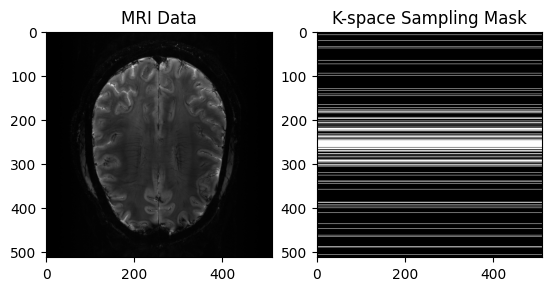

In [12]:
# Loading input data
cartesian_ref_image = get_sample_data('2d-pmri')
image = np.linalg.norm(cartesian_ref_image, axis=0)
# Obtain MRI cartesian mask
mask = get_sample_data("cartesian-mri-mask").data

# View Input
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

In [3]:
mask_sampled = np.where(mask==1)
print(512**2/np.size(mask_sampled))

2.6122448979591835


[ 0.          0.00195312 -0.00195312  0.00390625 -0.00390625  0.00585938
 -0.00585938  0.0078125  -0.0078125   0.00976562 -0.00976562  0.01171875
 -0.01171875  0.01367188 -0.01367188  0.015625   -0.015625    0.01757812
 -0.01757812  0.01953125 -0.01953125  0.02148438 -0.02148438  0.0234375
 -0.0234375   0.02539062 -0.02539062  0.02734375 -0.02734375  0.02929688
 -0.02929688  0.03125    -0.03125     0.03320312 -0.03320312  0.03515625
 -0.03515625  0.03710938 -0.03710938  0.0390625  -0.0390625   0.04101562
 -0.04101562  0.04296875 -0.04296875  0.04492188 -0.04492188  0.046875
 -0.046875    0.05078125 -0.04882812  0.0625     -0.05078125  0.0703125
 -0.05664062  0.07226562 -0.0703125   0.08789062 -0.078125    0.09375
 -0.08203125  0.09765625 -0.08398438  0.1015625  -0.09375     0.13085938
 -0.09570312  0.13476562 -0.09765625  0.15039062 -0.1015625   0.15234375
 -0.109375    0.16796875 -0.125       0.16992188 -0.1328125   0.18554688
 -0.13476562  0.18945312 -0.13867188  0.19140625 -0.144531

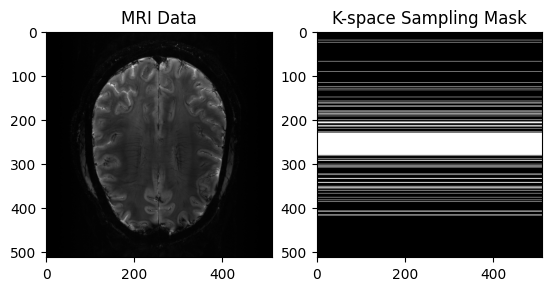

In [5]:
# Alternative design of 1D VDS
from mrinufft.trajectories.tools import get_random_loc_1d

phase_encoding_locs = get_random_loc_1d(image.shape[0], accel=8, center_prop=0.1, pdf='gaussian')
print(phase_encoding_locs, min(phase_encoding_locs), max(phase_encoding_locs))
phase_encoding_locs = ((phase_encoding_locs +0.5) * image.shape[0]).astype(int)
mask = np.zeros(image.shape, dtype=bool)
mask[phase_encoding_locs] = 1

# View Input
plt.subplot(1, 2, 1)
plt.imshow(np.abs(image), cmap='gray')
plt.title("MRI Data")
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("K-space Sampling Mask")
plt.show()

## Generate the kspace

From the 2D brain slice and the acquisition mask, we retrospectively undersample the k-space using a cartesian acquisition mask. We then reconstruct the zero order solution as a baseline


In [13]:
# Get the locations of the kspace samples and the associated observations
fourier_op = FFT(mask=mask, shape=image.shape,
                 n_coils=cartesian_ref_image.shape[0])
kspace_obs = fourier_op.op(cartesian_ref_image)

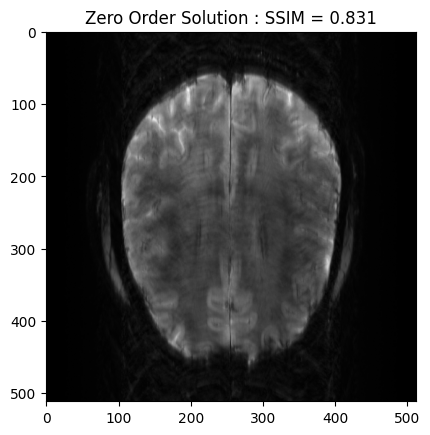

In [14]:
# Zero order solution
zero_soln = np.linalg.norm(fourier_op.adj_op(kspace_obs), axis=0)
base_ssim = ssim(zero_soln, image)
plt.imshow(np.abs(zero_soln), cmap='gray')
plt.title('Zero Order Solution : SSIM = ' + str(np.around(base_ssim, 3)))
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.3s finished


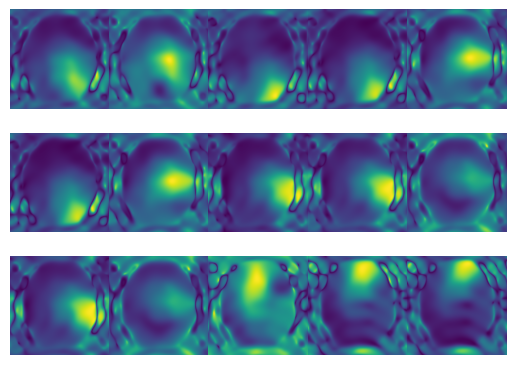

In [15]:
# Obtain SMaps
kspace_loc = convert_mask_to_locations(mask)
Smaps, SOS = get_Smaps(
    k_space=kspace_obs,
    img_shape=fourier_op.shape,
    samples=kspace_loc,
    thresh=(0.01, 0.01),    # The cutoff threshold in each kspace direction
                            # between 0 and kspace_max (0.5)
    min_samples=kspace_loc.min(axis=0),
    max_samples=kspace_loc.max(axis=0),
    mode='gridding',
    method='linear',
    n_cpu=-1,
)

h=3;w=5;
f, axs = plt.subplots(h,w)
for i in range(h):
    for j in range(w):
        axs[i, j].imshow(np.abs(Smaps[3 * i + j]))
        axs[i, j].axis('off')
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

## FISTA optimization

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost


In [16]:
# Setup the operators
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4,
)
regularizer_op = SparseThreshold(Identity(), 1.5e-8, thresh_type="soft")

In [17]:
# Setup Reconstructor
reconstructor = SelfCalibrationReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    kspace_portion=0.01,
    verbose=1,
)

Lipschitz constant is 1.0983724828872625
The lipschitz constraint is satisfied
 - mu:  1.5e-08
 - lipschitz constant:  1.0983724828872625
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x776fb38239d0> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  98.67630440200446  seconds
----------------------------------------


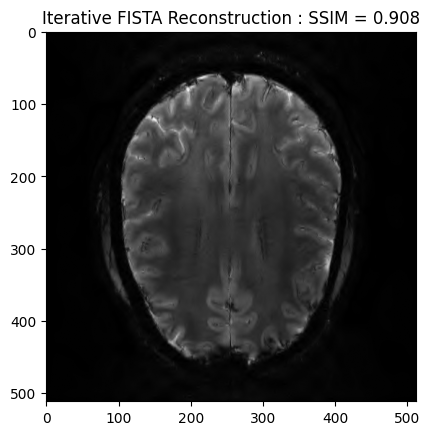

In [18]:
image_rec, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)
recon_ssim = ssim(image_rec, image)
plt.imshow(np.abs(image_rec), cmap='gray')
plt.title('Iterative FISTA Reconstruction : SSIM = ' + str(np.around(recon_ssim, 3)))
plt.show()

## POGM reconstruction

Lipschitz constant is 1.09836964369987
The lipschitz constraint is satisfied
 - mu:  1.5e-08
 - lipschitz constant:  1.09836964369987
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x776fb38239d0> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


  0%|          | 0/200 [00:00<?, ?it/s]

 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  101.1655332060036  seconds
----------------------------------------


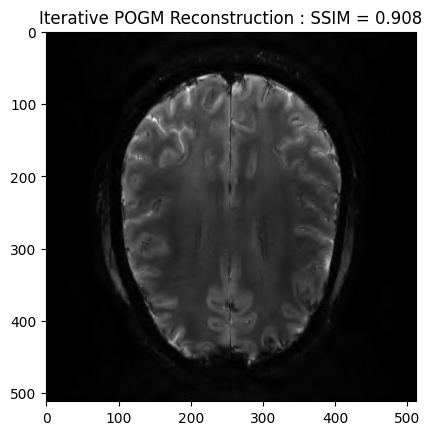

In [20]:
image_rec2, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_obs,
    optimization_alg='fista',
    num_iterations=200,
)
recon2_ssim = ssim(image_rec2, image)
plt.imshow(np.abs(image_rec2), cmap='gray')
plt.title('Iterative POGM Reconstruction : SSIM = ' + str(np.around(recon2_ssim, 3)))
plt.show()